# Data Project

> **Note:** 
> 1. This is a starting point for how to structure your data project 
> 1. The `dataproject.py` file includes functions which can be in this notebook

Import and set magics:

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1 Aggregate inflation in Denmark

We load the data from statistik banken

In [17]:
#%pip install git+https://github.com/alemartinello/dstapi
#%pip install fredapi

In [18]:
# APIs
from fredapi import Fred
from dstapi import DstApi

PRIS113 = DstApi('PRIS113') 

### 1-1 Basics

### 1-2 Instantaneous inflation

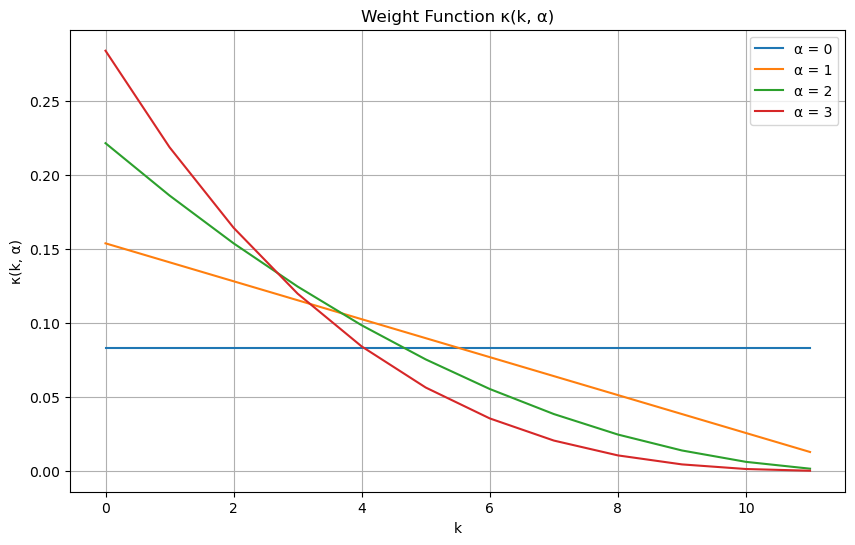

In [19]:
# Step 1: Define and plot κ(k, α)
k_values = np.arange(12)
alpha_values = [0, 1, 2, 3]
T = 12

plt.figure(figsize=(10, 6))
for alpha in alpha_values:
    kappa = (T - k_values) ** alpha / np.sum((T - np.arange(T)) ** alpha)
    plt.plot(k_values, kappa, label=f'α = {alpha}')
plt.xlabel('k')
plt.ylabel('κ(k, α)')
plt.title('Weight Function κ(k, α)')
plt.legend()
plt.grid()
plt.show()

## Question 2

We process the data by ...

In [25]:
data = dataproject.process_data(data)

TypeError: argument of type 'NoneType' is not iterable

TypeError: 'NoneType' object is not subscriptable

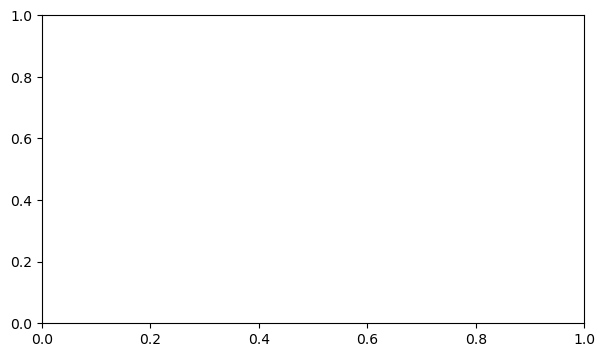

In [26]:
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111)

ax.plot(data['log_GDP'],label='log(GDP)')

ax.set_title('Log GDP over time')
ax.set_xlabel('Year')
ax.set_ylabel('Log GDP')

ax.legend();

We find that that ...